# Project: Anomaly Detection in ECG Signals
### by Tran Minh Duong - Exchange student from USTH

Bonjour M. Menard, M. Franco,

J'espère que vous avez passé de bonnes vacances de Toussaint. Ceci est mon jupyter notebook sur le project de Détection d'anomalies dans les signaux ECG. Merci de me permettre d'utiliser l'anglais dans ce notebook pour ma commodité. Merci et bonne lecture.

## Part 0: Install needed dependencies
- scipy
- pytorch
- numpy
- scikit-learn
- matplotlib
- seaborn
- torchsummary

In [1]:
# Install needed libraries: scipy, pytorch, numpy, scikit-learn and visualizations
%pip install --quiet scipy torch numpy scikit-learn matplotlib seaborn torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Part 1: Data Visualization and EDA

In [ ]:
# Load dada from ecg_dataset.mat
file_path = "./ecg_dataset.mat"

try:
    mat_data = scipy.io.loadmat(file_path)
    print("File loaded successfully!")
    # print("\nType of loaded data:", type(mat_data))
    # print("Keys (variable names) in the .mat file:", mat_data.keys())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please make sure it's in the same directory as your script or provide the full path.")


File loaded successfully!


In [4]:
# Extract signals and their labels, print their shapes
signals = mat_data['X']
labels = mat_data['y'].flatten()
print(f"Shape of labels: {labels.shape}")
print(f"Shape of signals array: {signals.shape}")

Shape of labels: (5405,)
Shape of signals array: (5405, 146)


In [5]:
# Count the occurrences of each class
class_counts = np.bincount(labels)
class_names = ['N (Normal)', 'R (Known Anomaly)', 'V (Unknown Anomaly)']

print("\nClass Distribution:")
for i, count in enumerate(class_counts):
    print(f"  Class {class_names[i]}: {count} samples")


Class Distribution:
  Class N (Normal): 5288 samples
  Class R (Known Anomaly): 111 samples
  Class V (Unknown Anomaly): 6 samples


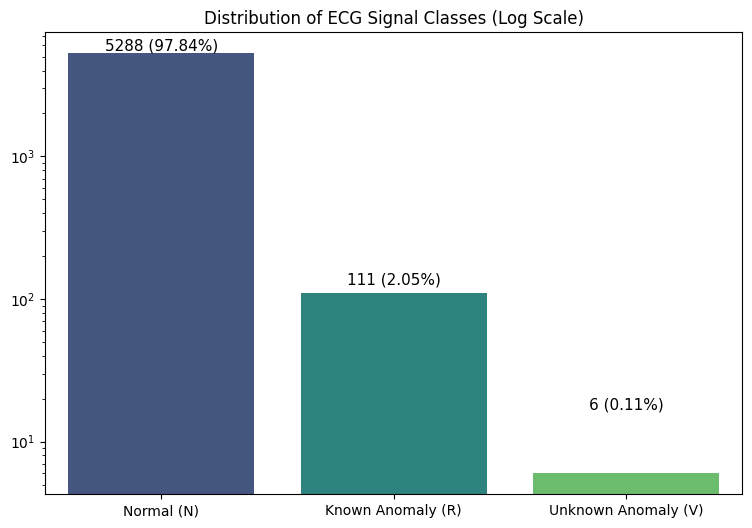

In [6]:
# Visualization of class distribution

class_counts = np.bincount(labels)
class_names = ['Normal (N)', 'Known Anomaly (R)', 'Unknown Anomaly (V)']

plt.figure(figsize=(9, 6))
total = class_counts.sum()
for index, value in enumerate(class_counts):
    plt.text(index, value + 10, f"{value} ({value/total*100:.2f}%)", 
             ha='center', va='bottom', fontsize=11)

plt.yscale('log') # Since the distribution is very unbalanced, I use log scale to better visualize it
sns.barplot(x=class_names, y=class_counts, hue=class_names, palette='viridis', legend=False)
plt.title('Distribution of ECG Signal Classes (Log Scale)')
plt.show()

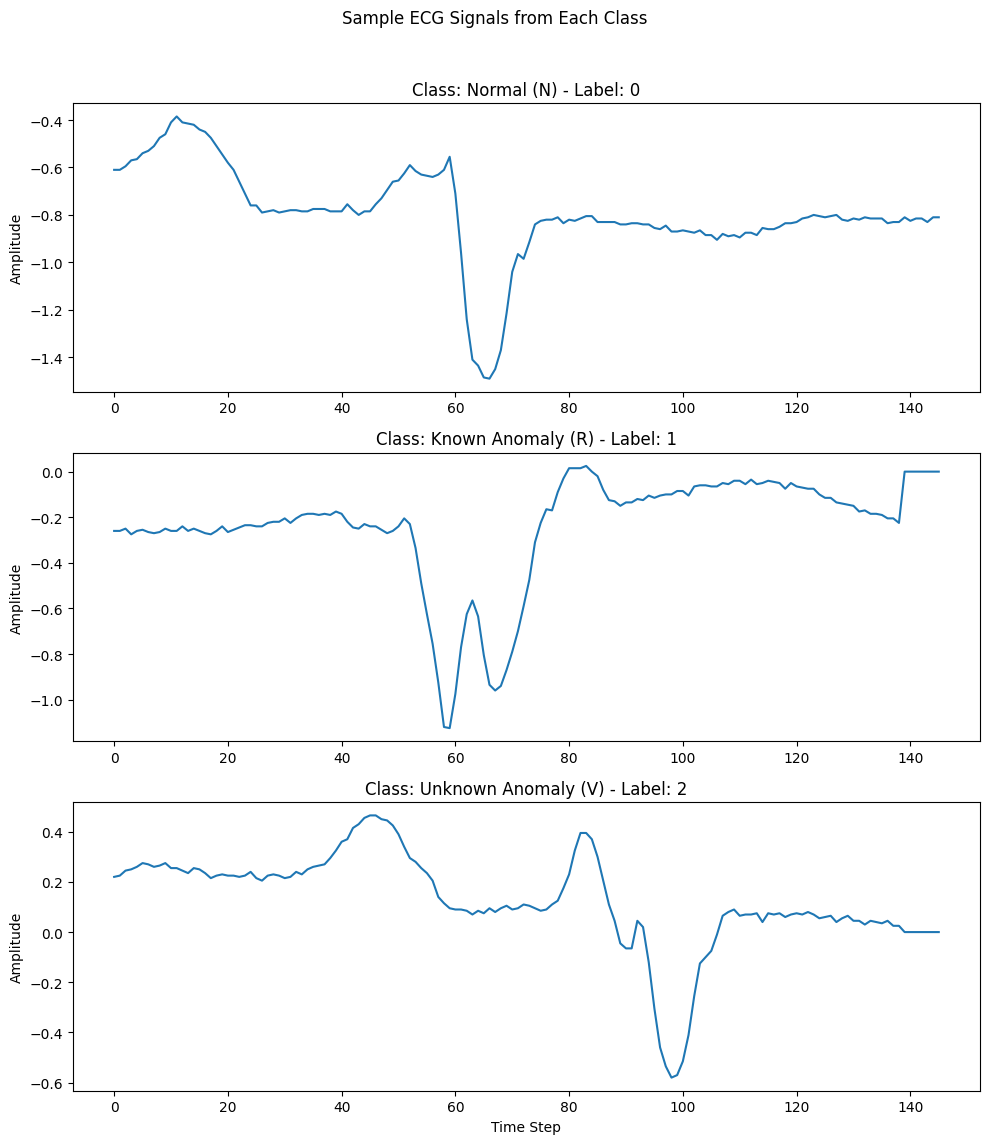

In [7]:
# Grab a random sample for each class of signal
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Sample ECG Signals from Each Class')

for i, class_name in enumerate(class_names):
    # Find the first index of a signal belonging to the current class
    idx = np.where(labels == i)[0][0]
    
    # Plot the signal
    axs[i].plot(signals[idx, :])
    axs[i].set_title(f'Class: {class_name} - Label: {i}')
    axs[i].set_ylabel('Amplitude')

plt.xlabel('Time Step')
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

In [8]:
# We group the last 2 classes into a single class named "anomalies"
# 0 : class N
# 1 : class R + V

# Use boolean indexing to filter the data based on labels
X_normal = signals[labels == 0]
y_normal = labels[labels == 0]

X_anomalies = signals[labels > 0] # Selects both Class 1 and 2
y_anomalies = labels[labels > 0]

print(f"Number of normal signals: {X_normal.shape[0]}")
print(f"Number of anomaly signals: {X_anomalies.shape[0]}")

Number of normal signals: 5288
Number of anomaly signals: 117


In [9]:
from sklearn.model_selection import train_test_split

# Split the normal signals into 70% training, 20% validation and 10% test 
# (the test includes the remaining anomalies classes)

print("--- Starting the 70:20:10 Data Split ---")
print(f"Total normal signals available: {len(X_normal)}")
print(f"Total anomaly signals available: {len(X_anomalies)}")

# Step 1: First split (70% for training, 30% for temp)
X_train, X_temp_normal, y_train, y_temp_normal = train_test_split(
    X_normal, y_normal,
    train_size=0.7,
    random_state=42
)
print(f"\nStep 1: Created training set with {len(X_train)} samples (70% of normal).")


# Step 2: Second split (split the remaining 30% into 20% and 10%) for validation and test sets
# The temp pool has 30% of the original data. To get 20% and 10%, we split this
# pool in a 2:1 ratio (20 is 2/3 of 30, and 10 is 1/3 of 30).
X_val, X_test_normal, y_val, y_test_normal = train_test_split(
    X_temp_normal, y_temp_normal,
    test_size=(1/3), # 1/3 of the 30% pool will be our 10% test set part
    random_state=42
)
print(f"Step 2: Created validation set with {len(X_val)} samples (~20% of normal).")
print(f"Step 2: Created a normal portion for the test set with {len(X_test_normal)} samples (~10% of normal).")


# Step 3: Construct the final, mixed test set
# Combine the normal part of the test set with ALL anomalies.
X_test = np.concatenate([X_test_normal, X_anomalies])
y_test = np.concatenate([y_test_normal, y_anomalies])
print(f"\nStep 3: Final test set created with {len(X_test)} total samples.")

# --- FINAL SUMMARY ---
print("\n--- Final Data Shapes ---")
print(f"Training Set (X_train):   {X_train.shape} -> Used for training (normal only)")
print(f"Validation Set (X_val):   {X_val.shape} -> Used for finding the threshold (normal only)")
print(f"Test Set (X_test):        {X_test.shape} -> Used for final evaluation (mixed normal and anomaly)")

--- Starting the 70:20:10 Data Split ---
Total normal signals available: 5288
Total anomaly signals available: 117

Step 1: Created training set with 3701 samples (70% of normal).
Step 2: Created validation set with 1058 samples (~20% of normal).
Step 2: Created a normal portion for the test set with 529 samples (~10% of normal).

Step 3: Final test set created with 646 total samples.

--- Final Data Shapes ---
Training Set (X_train):   (3701, 146) -> Used for training (normal only)
Validation Set (X_val):   (1058, 146) -> Used for finding the threshold (normal only)
Test Set (X_test):        (646, 146) -> Used for final evaluation (mixed normal and anomaly)


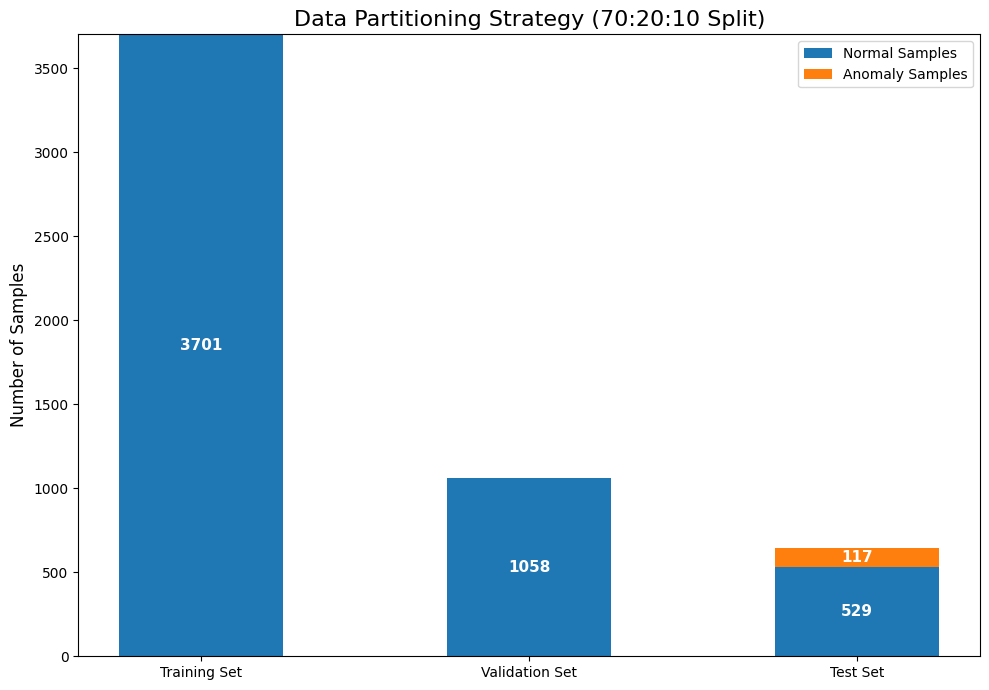

In [10]:
# BAR CHART: Plot the distribution of classes after partitioning

# --- 1. Get the sizes of each component from your new split ---
n_train = len(X_train)
n_val = len(X_val)
n_test_normal = len(X_test_normal)
n_test_anomaly = len(X_anomalies)

# --- 2. Define labels and data for the three-bar plot ---
labels = ['Training Set', 'Validation Set', 'Test Set']
normal_counts = [n_train, n_val, n_test_normal]
anomaly_counts = [0, 0, n_test_anomaly]  # Anomalies are still only in the test set

# --- 3. Create the stacked bar chart ---
plt.figure(figsize=(10, 7))
width = 0.5 # Width of the bars

plt.bar(labels, normal_counts, width, label='Normal Samples', color='#1f77b4')
plt.bar(labels, anomaly_counts, width, bottom=normal_counts, label='Anomaly Samples', color='#ff7f0e')

# --- 4. Add title, labels, and legend ---
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Data Partitioning Strategy (70:20:10 Split)', fontsize=16)
plt.legend()

# --- 5. Add text annotations inside the bars for clarity ---
for i in range(len(labels)):
    if normal_counts[i] > 0:
        plt.text(i, normal_counts[i] / 2, str(normal_counts[i]), 
                 ha='center', va='center', color='white', fontsize=11, fontweight='bold')
    if anomaly_counts[i] > 0:
        plt.text(i, normal_counts[i] + anomaly_counts[i] / 2, str(anomaly_counts[i]), 
                 ha='center', va='center', color='white', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

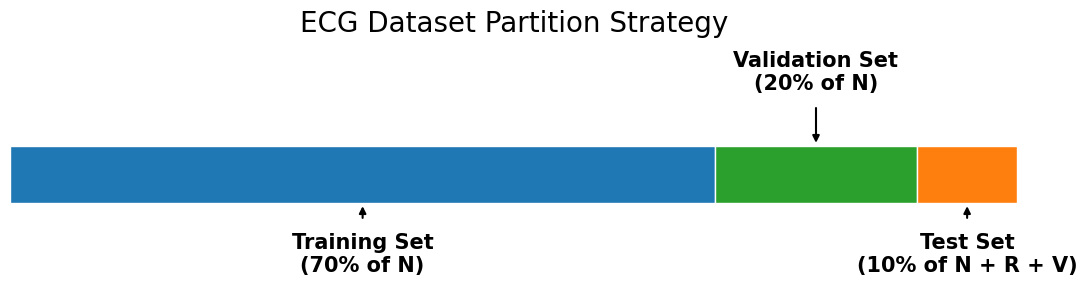

In [11]:
# PIPE CHART: still the same idea but it's better to visualize the separation of data

sizes = [0.7, 0.2, 0.1]
labels = [
    'Training Set\n(70% of N)',
    'Validation Set\n(20% of N)',
    'Test Set\n(10% of N + R + V)'
]
colors = ['#1f77b4', '#2ca02c', '#ff7f0e']
fig, ax = plt.subplots(figsize=(13, 3))
left = 0
y_bar = 0.5

# --- Draw each segment ---
for i, size in enumerate(sizes):
    ax.barh(y_bar, size, left=left, color=colors[i], edgecolor='white', height=0.25)
    
    if i == 1: # Middle label (Validation Set) goes on top
        y_arrow_start = y_bar + 0.125
        y_arrow_end = y_bar + 0.3
        y_text_pos = y_bar + 0.35
        vertical_alignment = 'bottom'
    else: # First and last labels go below
        y_arrow_start = y_bar - 0.125
        y_arrow_end = y_bar - 0.2
        y_text_pos = y_bar - 0.25
        vertical_alignment = 'top'

    # Arrow to label
    ax.annotate('',
                xy=(left + size/2, y_arrow_start),
                xytext=(left + size/2, y_arrow_end),
                arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5))
    # Label
    ax.text(left + size/2, y_text_pos, labels[i],
            ha='center', va=vertical_alignment, fontsize=15, fontweight='bold', color='black')
    left += size

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_axis_off()
plt.title('ECG Dataset Partition Strategy', fontsize=20, pad=20)
plt.show()

## Part 2: Data Preprocessing

In this part, we use standardization to preprocess our data, it basically **center and reduce** our data to have the **mean = 0** and **standard deviation = 1**.

The formula for standardization is shown below:
$$
signal_{\text{new}} = \frac{signal - \mu}{\sigma}
$$
where $\mu$ is the mean of the **training data** and $\sigma$ is its standard deviation

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) 
#This first function call tells the scaler to standardize the data with the mean and sttdev of X_train

# These 2 functions below will use the same mean and stddev of X_train
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Verify the results
print("\nData after standardization:")
print(f"Mean/Stddev of scaled training data: {X_train_scaled.mean():.2f}/{X_train_scaled.std():.2f}")
print(f"Mean/Stddev of scaled validation data: {X_val_scaled.mean():.2f}/{X_val_scaled.std():.2f}")
print(f"Mean/Stddev of scaled test data: {X_test_scaled.mean():.2f}/{X_test_scaled.std():.2f}")

# Note that the mean/stddev of X_val and X_test is not 0/1 because we're using the X_train to standardize it
# This is very important because it prevents data leakage


Data after standardization:
Mean/Stddev of scaled training data: 0.00/1.00
Mean/Stddev of scaled validation data: -0.02/1.00
Mean/Stddev of scaled test data: 0.03/0.97


## Part 3: Methodology - Defining Model Architecture and Training
In this part we use Pytorch to build the model architecture: **An Autoencoder** and use it to train on our dataset.

Note that this is a semi-supervised strategy:

- We only train this model with the train set containing normal signals

- Then we use the validation set to define the suitable threshold

- Finally we use that threshold to evaluate on the test set

### 3.1. Model Architecture

In [13]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3, stride=2), # Output: (N, 16, 73)
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=7, padding=3, stride=2), # Output: (N, 32, 37)
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, padding=3, stride=2)  # Output: (N, 64, 19)
        )
        
        # --- Decoder ---
        self.decoder = nn.Sequential(
            # Layer 1: Takes latent space (19) and aims for 37
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=7, padding=3, stride=2, 
                               output_padding=0),
            nn.ReLU(),
            
            # Layer 2: Takes 37 and aims for 73
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=7, padding=3, stride=2, 
                               output_padding=0),
            nn.ReLU(),

            # Layer 3: Takes 73 and aims for 146
            nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=7, padding=3, stride=2, 
                               output_padding=1),
            
            # IMPORTANT: Since we standardize our data in the processing part, we have to revert it back for the output signal. Therefore I choose the Tanh activation
            nn.Tanh() # To scale output between -1 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
# Test the implementation of the model
model = ConvAutoencoder()
print("Model Architecture:")
print(model)

# Test the model by comparing the input and output of a dummy signal
dummy_input = torch.randn(4, 1, 146)
print(f"\nShape of dummy input: {dummy_input.shape}")

# Pass the dummy data through the model
output = model(dummy_input)
print(f"Shape of model output: {output.shape}")

# Check if the output shape is the same as the input shape
if dummy_input.shape == output.shape:
    print("\nSuccess! The output shape matches the input shape.")
else:
    print("\nError! The output shape does not match the input shape.")

Model Architecture:
ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (3): ReLU()
    (4): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): ReLU()
    (2): ConvTranspose1d(32, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (3): ReLU()
    (4): ConvTranspose1d(16, 1, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (5): Tanh()
  )
)

Shape of dummy input: torch.Size([4, 1, 146])
Shape of model output: torch.Size([4, 1, 146])

Success! The output shape matches the input shape.


In [15]:
# Print the architecture of the model, layer by layer
# And also the size (in megabytes) and the total trainable parameters
from torchsummary import summary

device = torch.device('cpu')
model = ConvAutoencoder().to(device)

# The input_size should be (channels, length)
print("="*60)
print("                 Model Architecture Summary")
print("="*60)
summary(model, input_size=(1, 146))

                 Model Architecture Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 73]             128
              ReLU-2               [-1, 16, 73]               0
            Conv1d-3               [-1, 32, 37]           3,616
              ReLU-4               [-1, 32, 37]               0
            Conv1d-5               [-1, 64, 19]          14,400
   ConvTranspose1d-6               [-1, 32, 37]          14,368
              ReLU-7               [-1, 32, 37]               0
   ConvTranspose1d-8               [-1, 16, 73]           3,600
              ReLU-9               [-1, 16, 73]               0
  ConvTranspose1d-10               [-1, 1, 146]             113
             Tanh-11               [-1, 1, 146]               0
Total params: 36,225
Trainable params: 36,225
Non-trainable params: 0
-----------------------------------------------------

### 3.2. Dataloaders

In [16]:
# Pytorch use a datatype called "Tensor" to train its model
# Therefore, we have to convert all the float type of the original signal to tensor
from torch.utils.data import DataLoader, TensorDataset

train_tensors = torch.from_numpy(X_train_scaled).float()
train_tensors = train_tensors.unsqueeze(1) # Add the channel dimension at index 1

val_tensors = torch.from_numpy(X_val_scaled).float()
val_tensors = val_tensors.unsqueeze(1)

#Convert test data (we'll use this later for evaluation)
test_tensors = torch.from_numpy(X_test_scaled).float()
test_tensors = test_tensors.unsqueeze(1)

# Check the new shapes
print("Shape of training tensors:", train_tensors.shape)
print("Shape of validation tensors:", val_tensors.shape)
print("Shape of test tensors:", test_tensors.shape)

Shape of training tensors: torch.Size([3701, 1, 146])
Shape of validation tensors: torch.Size([1058, 1, 146])
Shape of test tensors: torch.Size([646, 1, 146])


In [17]:
# Time to pass our data into a tensor dataset
# For an autoencoder, the input and the target are the same so we just pass the tensors as an argument twice
train_dataset = TensorDataset(train_tensors, train_tensors)
val_dataset = TensorDataset(val_tensors, val_tensors)

In [18]:
# Define batch size, which is the number of signals that the model use to compute gradients, 
# then update its weights for every iteration 
BATCH_SIZE = 64

# Create the training DataLoader
# shuffle=True is very important for training
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create the validation DataLoader
# No need to shuffle validation data
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# Test: Get one batch of training data
data_iter = iter(train_loader)
signals_batch, targets_batch = next(data_iter)

print("\n--- Verifying the DataLoader ---")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Shape of one batch of signals: {signals_batch.shape}")
print(f"Shape of one batch of targets: {targets_batch.shape}")


--- Verifying the DataLoader ---
Number of batches in train_loader: 58
Shape of one batch of signals: torch.Size([64, 1, 146])
Shape of one batch of targets: torch.Size([64, 1, 146])


### 3.3. Choosing hyperparameters, criterion and optimizer

In [20]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ConvAutoencoder()
model.to(device) #Send the model to our device

# Defining the Loss Function, in this case it's the Mean Square Error
criterion = nn.MSELoss()

# Defining the Optimizer
# We pass the model's parameters to the optimizer so it knows what to update.
# 'lr' stands for INITIAL learning rate. 0.001 is a good starting point (trust me).
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nLoss Function:", criterion)
print("Optimizer:", optimizer)

Using device: cpu

Loss Function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### 3.4. Training the autoencoder
(finally)

In [21]:
import torch
import time

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    """
    Function to train the autoencoder model.
    
    Args:
        model (nn.Module): The autoencoder model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): The loss function (e.g., MSELoss).
        optimizer (torch.optim): The optimizer (e.g., Adam).
        num_epochs (int): The number of epochs to train for.
        
    Returns:
        tuple: A tuple containing the trained model and a dictionary of loss history.
    """
    # Keep track of the best model and loss history
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    
    # Start timer
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
        
        # --- Training Phase ---
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        
        for signals_batch, _ in train_loader:
            # Move data to the configured device (GPU/CPU)
            signals_batch = signals_batch.to(device)
            
            # 1. Zero the parameter gradients
            optimizer.zero_grad()
            
            # 2. Forward pass: compute predicted outputs
            outputs = model(signals_batch)
            
            # 3. Calculate the loss
            loss = criterion(outputs, signals_batch)
            
            # 4. Backward pass: compute gradient of the loss
            loss.backward()
            
            # 5. Perform a single optimization step (parameter update)
            optimizer.step()
            
            # Accumulate the training loss
            running_train_loss += loss.item() * signals_batch.size(0)
            
        # --- Validation Phase ---
        model.eval()   # Set the model to evaluation mode
        running_val_loss = 0.0
        
        with torch.no_grad(): # Disable gradient calculation for validation
            for signals_batch, _ in val_loader:
                signals_batch = signals_batch.to(device)
                
                # Forward pass
                outputs = model(signals_batch)
                
                # Calculate the loss
                loss = criterion(outputs, signals_batch)
                
                # Accumulate the validation loss
                running_val_loss += loss.item() * signals_batch.size(0)
                
        # Calculate average losses for the epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        
        print(f"Training Loss: {epoch_train_loss:.6f} | Validation Loss: {epoch_val_loss:.6f}")
        
        # Store loss history for plotting
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        
        # Save the best model (lowest validation loss)
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            print("  => New best model saved!")

    # Print total training time
    time_elapsed = time.time() - start_time
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation Loss: {best_loss:.6f}")
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [22]:
NUM_EPOCHS = 30 # We can choose a higher number but I think with Adam, this is enough to converge

# Let's start the training! yay
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS
)

Epoch 1/30
----------
Training Loss: 0.603378 | Validation Loss: 0.507747
  => New best model saved!
Epoch 2/30
----------
Training Loss: 0.486516 | Validation Loss: 0.476921
  => New best model saved!
Epoch 3/30
----------
Training Loss: 0.470459 | Validation Loss: 0.471084
  => New best model saved!
Epoch 4/30
----------
Training Loss: 0.466659 | Validation Loss: 0.468673
  => New best model saved!
Epoch 5/30
----------
Training Loss: 0.464723 | Validation Loss: 0.466957
  => New best model saved!
Epoch 6/30
----------
Training Loss: 0.463302 | Validation Loss: 0.466378
  => New best model saved!
Epoch 7/30
----------
Training Loss: 0.462610 | Validation Loss: 0.465352
  => New best model saved!
Epoch 8/30
----------
Training Loss: 0.461935 | Validation Loss: 0.464879
  => New best model saved!
Epoch 9/30
----------
Training Loss: 0.461541 | Validation Loss: 0.464406
  => New best model saved!
Epoch 10/30
----------
Training Loss: 0.461176 | Validation Loss: 0.464176
  => New best mo

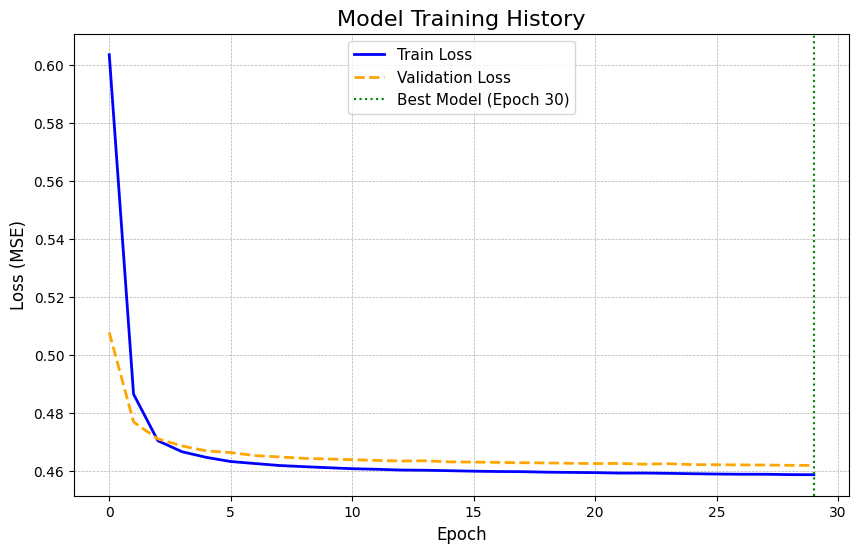

In [23]:
# Plotting the train loss and validation loss

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)

# Find the epoch with the best validation loss (which your function saved)
best_epoch = np.argmin(history['val_loss'])
plt.axvline(x=best_epoch, color='green', linestyle=':', 
            label=f'Best Model (Epoch {best_epoch+1})')

plt.title('Model Training History', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

## Part 4: Determination of the optimal threshold

Now that we have the model, let's next:

- Plot the error distribution

- Use a **90th percentile** to choose the threshold

This ensures that if an anomaly was to be passed into the model, the output signal would have high error ==> Anomaly detected

In [24]:
def get_reconstruction_errors(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    
    criterion = nn.MSELoss(reduction='none') 
    
    with torch.no_grad():
        for signals_batch, _ in data_loader:
            signals_batch = signals_batch.to(device)
            
            # Get model's reconstruction
            outputs = model(signals_batch)
            
            # Calculate loss for each signal in the batch
            # Shape of loss will be (batch_size, channels, length)
            loss = criterion(outputs, signals_batch)
            
            # Average the error across the channels and time steps for each signal
            # to get a single error value per signal
            per_sample_error = torch.mean(loss, dim=(1, 2))
            
            # Append the errors to our list (move to CPU and convert to numpy)
            reconstruction_errors.extend(per_sample_error.cpu().numpy())
            
    return np.array(reconstruction_errors)

print("Calculating reconstruction errors on the validation set...")
val_errors = get_reconstruction_errors(trained_model, val_loader, device)

print(f"Calculated {len(val_errors)} errors.")

Calculating reconstruction errors on the validation set...
Calculated 1058 errors.


The 90th percentile of the validation errors is: 0.111310


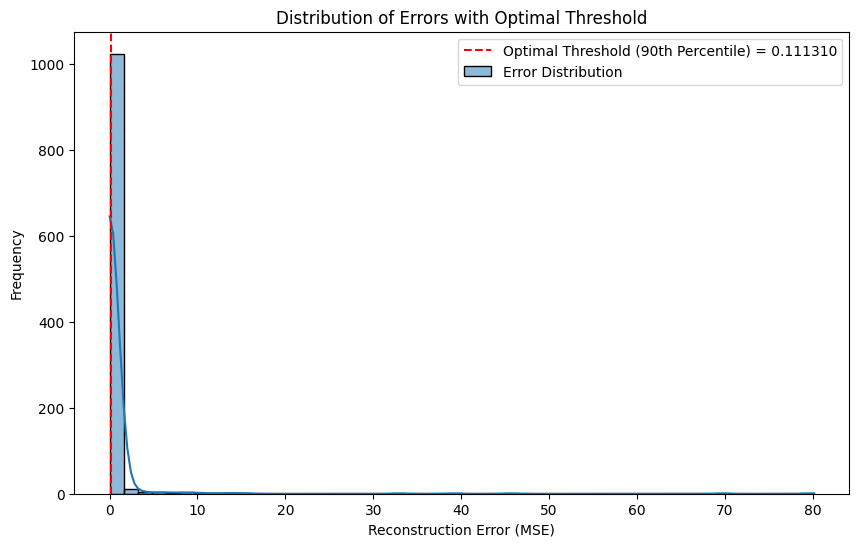

In [25]:
# Calculate the 90th percentile:
# This finds the error value that is greater than 99% of all other normal errors
percentile = 90
optimal_threshold = np.percentile(val_errors, percentile)

print(f"The {percentile}th percentile of the validation errors is: {optimal_threshold:.6f}")

# Plot the histogram just as you did
plt.figure(figsize=(10, 6))
sns.histplot(val_errors, bins=50, kde=True, label='Error Distribution')

# Add the optimal threshold as a vertical line
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal Threshold ({percentile}th Percentile) = {optimal_threshold:.6f}')

plt.title('Distribution of Errors with Optimal Threshold')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Part 5: Evaluation
Now that we have chosen a good threshold, let's evaluate our model by:

- Giving classification report with metrics such as accuracy, precision, recall, f1-score

- Plotting the confusion matrix to show many false negatives and false positifs

- Analyzing the false positives and false negatives cases to see why the model fails to capture them

- Plotting the time used for each inference so we can be sure that it does not exceed the 500ms constraint on Rasperry Pi

In [26]:
# Create a DataLoader for the test set
# The target here is the true label, which we'll use for evaluation
test_dataset = TensorDataset(test_tensors, torch.from_numpy(y_test).float())
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Binarize the true labels for comparison
# 0 -> 0 (Normal)
# 1, 2 -> 1 (Anomaly)
y_test_binary = (y_test > 0).astype(int)

print(f"Test set contains {len(y_test_binary)} samples.")
print(f"Number of anomalies in test set: {np.sum(y_test_binary)}")

Test set contains 646 samples.
Number of anomalies in test set: 117


Calculating reconstruction errors on the test set...

Using the optimal threshold of: 0.111310
Number of anomalies predicted: 156

--- Final Model Performance ---

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.99      0.91      0.95       529
 Anomaly (1)       0.71      0.94      0.81       117

    accuracy                           0.92       646
   macro avg       0.85      0.93      0.88       646
weighted avg       0.93      0.92      0.92       646



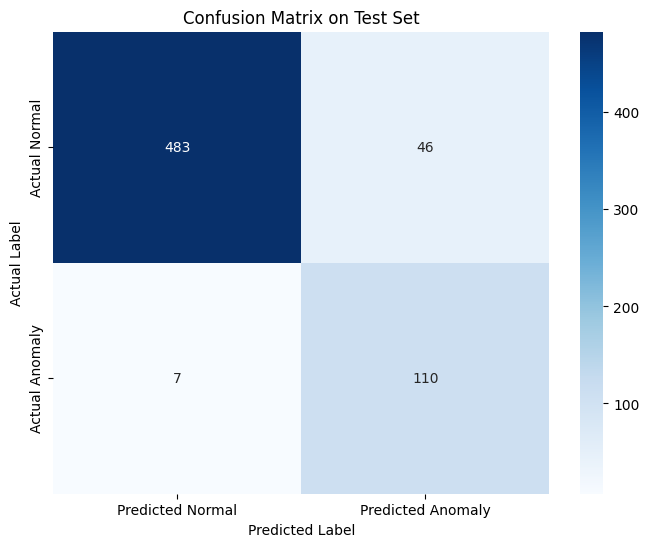

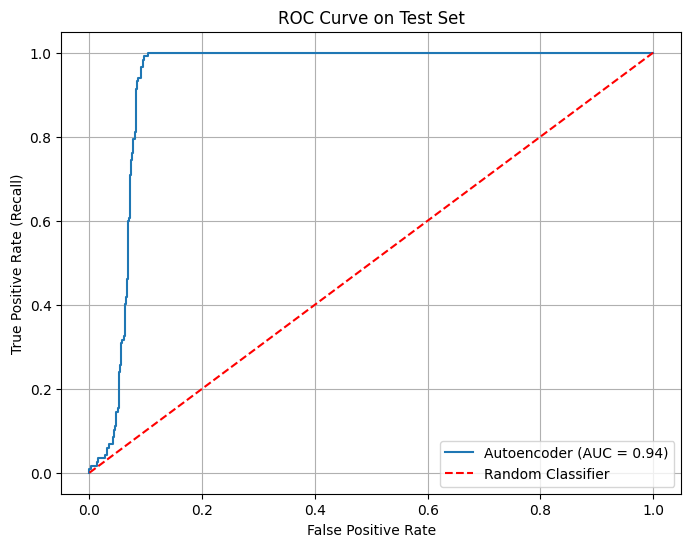


Final Area Under the Curve (AUC) on the test set: 0.9352


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

# 1. Get reconstruction errors for the test set
print("Calculating reconstruction errors on the test set...")
test_errors = get_reconstruction_errors(trained_model, test_loader, device)

# 2. Generate predictions using the optimal threshold
predictions = (test_errors > optimal_threshold).astype(int)

print(f"\nUsing the optimal threshold of: {optimal_threshold:.6f}")
print(f"Number of anomalies predicted: {np.sum(predictions)}")


# 3. Generate and Plot the Confusion Matrix & Classification Report
print("\n--- Final Model Performance ---")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_binary, predictions, target_names=['Normal (0)', 'Anomaly (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test_binary, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title('Confusion Matrix on Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# 4. Generate and Plot the Final ROC Curve
# The ROC curve uses the raw error scores, not the binary predictions.
fpr, tpr, thresholds_roc = roc_curve(y_test_binary, test_errors)
auc_score = roc_auc_score(y_test_binary, test_errors)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Autoencoder (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve on Test Set')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nFinal Area Under the Curve (AUC) on the test set: {auc_score:.4f}")

In [28]:
# Plotting a true positve, true negative and false negative case to see where the model is struggling:

def get_single_reconstruction(scaled_signal, model, scaler):
    """Feeds one scaled signal through the model and returns the inverse-transformed reconstruction."""
    device = torch.device('cpu')
    model.to(device)
    model.eval()
    
    # Add batch and channel dimensions: (1, 1, 146)
    signal_tensor = torch.from_numpy(scaled_signal).float().unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        reconstructed_tensor = model(signal_tensor)
    
    # Inverse transform to return to the original scale
    reconstructed_signal_scaled = reconstructed_tensor.cpu().numpy().squeeze()
    reconstructed_signal = scaler.inverse_transform(reconstructed_signal_scaled.reshape(1, -1)).flatten()
    
    return reconstructed_signal

In [29]:
# Find the indices for each case
# Case 1: Normal Correctly Detected (True Normal)
idx_tn = np.where((y_test_binary == 0) & (predictions == 0))[0]

# Case 2: Anomaly Correctly Detected (True Anomaly)
idx_ta = np.where((y_test_binary == 1) & (predictions == 1))[0]

# Case 3: Anomaly Falsely Detected as Normal (False Negative)
idx_fn = np.where((y_test_binary == 1) & (predictions == 0))[0]

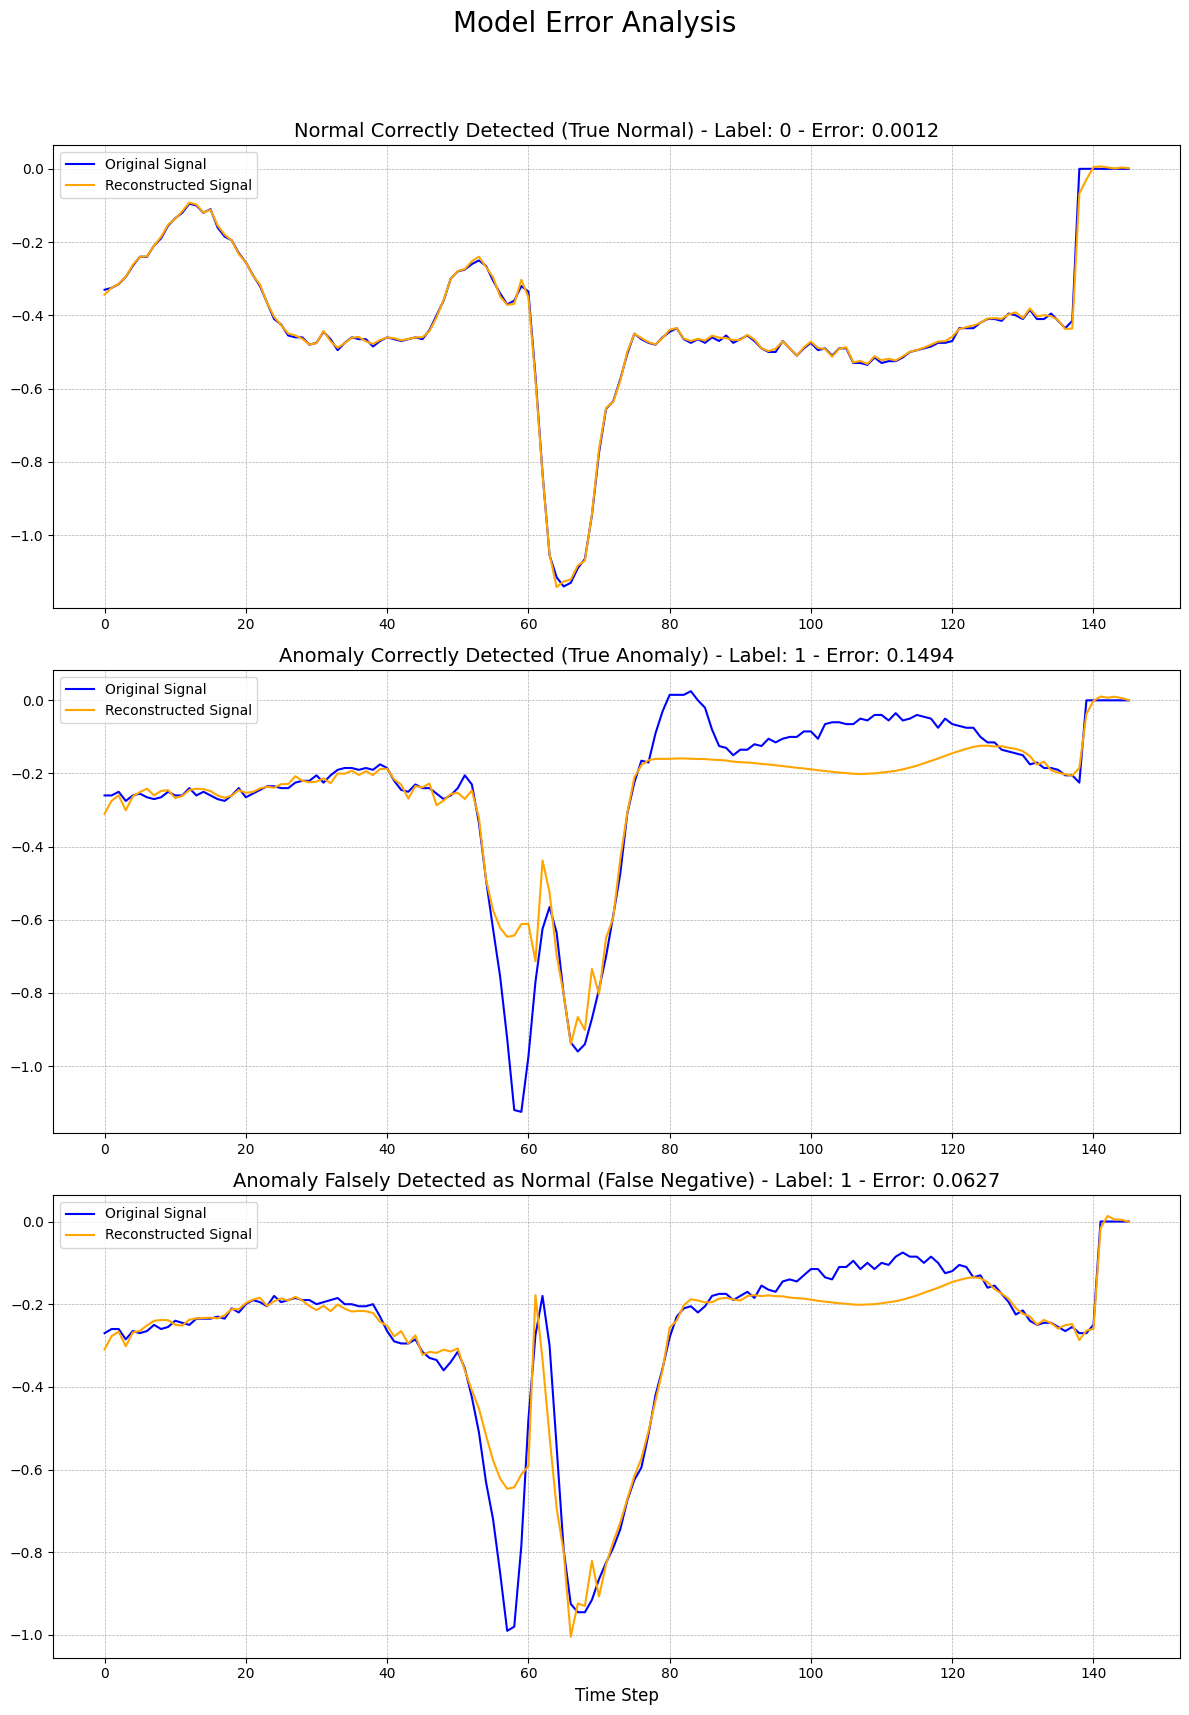

In [30]:
# Plotting:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Model Error Analysis', fontsize=20)

# --- Plot 1: True Normal (Normal as Normal) ---
if len(idx_tn) > 0:
    idx = idx_tn[0] # Get the first example
    original = X_test[idx]
    reconstructed = get_single_reconstruction(X_test_scaled[idx], trained_model, scaler)
    error = test_errors[idx]
    
    axs[0].plot(original, label='Original Signal', color='blue')
    axs[0].plot(reconstructed, label='Reconstructed Signal', color='orange')
    axs[0].set_title(f'Normal Correctly Detected (True Normal) - Label: 0 - Error: {error:.4f}', fontsize=14)
    axs[0].legend()
    axs[0].grid(True, linestyle='--', linewidth=0.5)
else:
    axs[0].set_title("No True Normals found in test set to display.")

# --- Plot 2: True Anomaly (Anomaly as Anomaly) ---
if len(idx_ta) > 0:
    idx = idx_ta[0] # Get the first example
    original = X_test[idx]
    reconstructed = get_single_reconstruction(X_test_scaled[idx], trained_model, scaler)
    error = test_errors[idx]
    
    axs[1].plot(original, label='Original Signal', color='blue')
    axs[1].plot(reconstructed, label='Reconstructed Signal', color='orange')
    axs[1].set_title(f'Anomaly Correctly Detected (True Anomaly) - Label: 1 - Error: {error:.4f}', fontsize=14)
    axs[1].legend()
    axs[1].grid(True, linestyle='--', linewidth=0.5)
else:
    axs[1].set_title("No True Anomalies found in test set to display.")

# --- Plot 3: False Negative (Anomaly as Normal) ---
if len(idx_fn) > 0:
    idx = idx_fn[0] # Get the first example
    original = X_test[idx]
    reconstructed = get_single_reconstruction(X_test_scaled[idx], trained_model, scaler)
    error = test_errors[idx]
    
    axs[2].plot(original, label='Original Signal', color='blue')
    axs[2].plot(reconstructed, label='Reconstructed Signal', color='orange')
    axs[2].set_title(f'Anomaly Falsely Detected as Normal (False Negative) - Label: 1 - Error: {error:.4f}', fontsize=14)
    axs[2].legend()
    axs[2].grid(True, linestyle='--', linewidth=0.5)
else:
    axs[2].set_title("No False Negatives found in test set to display!")

plt.xlabel('Time Step', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for the main title
plt.show()

From the figure above, we can see that the error of the false negative case is high

However, it falls right under our detection threshold (unlucky I guess :/ )

Anyways, we could improve this by decreasing the threshold by getting **the 85th percentile** for example

But the trade off is that we create more false postives so it's not worth it

I hope you're reading this part professor

In [32]:
# Ensure that the inference time is below 500ms on CPU
import time

# Ensure the model is in evaluation mode
trained_model.eval()
device = torch.device('cpu')
trained_model.to(device)

# Create a DataLoader for one-by-one inference
# We use batch_size=1 to simulate the real-time arrival of single heartbeats.
inference_dataset = TensorDataset(test_tensors, torch.from_numpy(y_test).float())
inference_loader = DataLoader(dataset=inference_dataset, batch_size=1, shuffle=False)

# Run the timing loop
inference_times = [] # List to store the time for each prediction
print(f"\nRunning inference test on all {len(inference_loader)} samples in the test set...")

# Disable gradient calculations to speed up inference
with torch.no_grad():
    for signal_batch, _ in inference_loader:
        # The batch (containing one signal) is already on the CPU
        signal_batch = signal_batch.to(device)
        
        start_time = time.time()
        _ = trained_model(signal_batch) # Perform the forward pass (prediction)
        end_time = time.time()
        
        # Calculate elapsed time in milliseconds and store it
        elapsed_time_ms = (end_time - start_time) * 1000
        inference_times.append(elapsed_time_ms)

print("Inference test complete.")



Running inference test on all 646 samples in the test set...
Inference test complete.


In [33]:
# Analyze and display the results
avg_time = np.mean(inference_times)
max_time = np.max(inference_times)
std_time = np.std(inference_times)

print("\n--- Inference Performance Results ---")
print(f"Average prediction time: {avg_time:.2f} ms")
print(f"Maximum (worst-case) prediction time: {max_time:.2f} ms")
print(f"Standard deviation of prediction times: {std_time:.2f} ms")

# Final Verdict on the Project Constraint
if avg_time < 500:
    print(f"\nSUCCESS: The average inference time of {avg_time:.2f} ms is well below the 500ms constraint.")
else:
    print(f"\nWARNING: The average inference time of {avg_time:.2f} ms exceeds the 500ms constraint.")


--- Inference Performance Results ---
Average prediction time: 0.43 ms
Maximum (worst-case) prediction time: 1.81 ms
Standard deviation of prediction times: 0.11 ms

SUCCESS: The average inference time of 0.43 ms is well below the 500ms constraint.


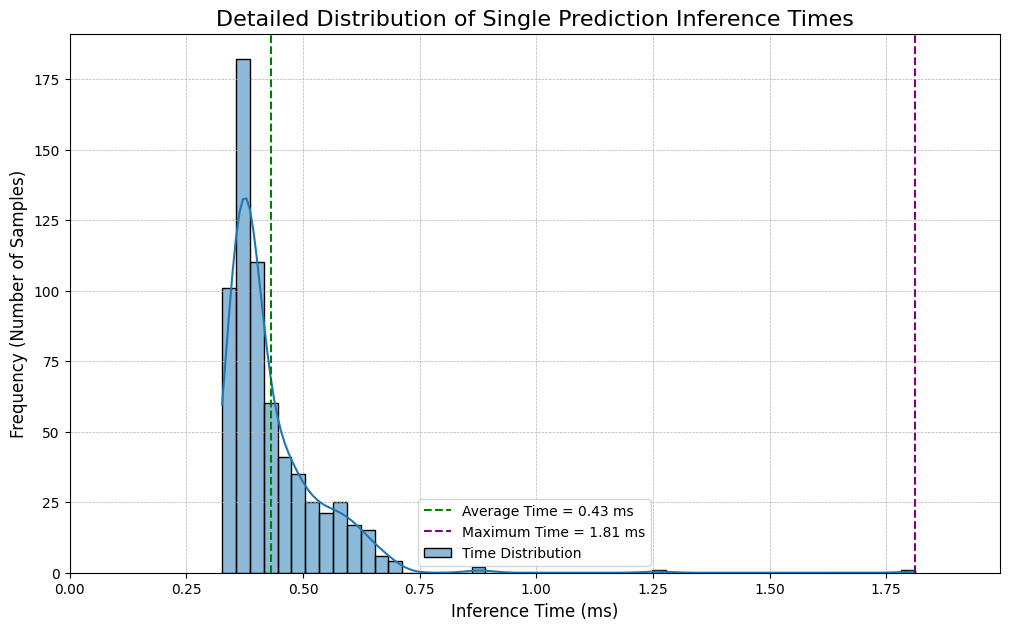

In [34]:
# Plotting the time-taken plot
plt.figure(figsize=(12, 7))

# Create a histogram and a kernel density estimate (KDE) plot
sns.histplot(inference_times, bins=50, kde=True, label='Time Distribution')

# --- Add Lines for Average and Maximum Time ---
# Add a vertical line for the average inference time
plt.axvline(x=avg_time, color='green', linestyle='--', 
            label=f'Average Time = {avg_time:.2f} ms')

# Add a vertical line for the maximum (worst-case) inference time
plt.axvline(x=max_time, color='purple', linestyle='--', 
            label=f'Maximum Time = {max_time:.2f} ms')

plt.xlim(0, max_time * 1.1) 
plt.title('Detailed Distribution of Single Prediction Inference Times', fontsize=16)
plt.xlabel('Inference Time (ms)', fontsize=12)
plt.ylabel('Frequency (Number of Samples)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

## Conclusion (please read)

To be honest, it was quite fun. Although I've done many machine learning / deep learning projects, this is my first time ever with a Semi-supervised learning approach.

I used LaTex to write the report and also, I drew the architecture of the 1D Convolutional Autoencoder by myself using draw.io. I hope you noticed and zoomed in to see it more clearly. 

Some of the figures/plots above were not included in my report because of the 4-pages limit.

If I was given **more pages to write**, I would:

- Use data augmentation in the preprocessing step to **introduce noise** into the signals, this helps enrich data and make it more robust.

- Add some references by citing researches

- Explain more about the flaw of the model (threshold too high or too low)

- Give future improvements: Use the **Variational Autoencoder** to compress the input into a range of continous, possible values. The latent space becomes more structured and continous, resulting in a clearer separation of anomalies in the reconstruction errors. ==> Easier to choose an optimal threshold

- Write more about literature review, I would explain more about:

    - The formula of MSE

    - What is a true postive, true negative, false positive, false negative

    - How to calculate metrics such as accuracy, precision, recall, f1-score

    - How convolution and convolution transpose work

    - ReLU and Tanh activation functions

**Thank you professor Menard and professor Franco for your lectures and guidances throughout the course. I hope you're stilling reading this, I wish you health and success in the career of teaching.**